In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
LibraryPath = r"D:\Учеба\Практика\Диплом\gamma"
sys.path.insert(0, LibraryPath)

In [3]:
from SpectrumsMeasurementsLibrary.GammaRayInteractions.Materials import Material, R
from SpectrumsMeasurementsLibrary.CrossSectionsLibrary.cross_sections_data import ENERGY_MESH
from SpectrumsMeasurementsLibrary.MeasurementInstrumentation.measurement_techniques import ideal_transmission_function, \
k_edge_method_transmission_function, ross_method_transmission_function, edges_indices

In [4]:
brem = R(50, 1e-2).mass_emitted_bremsstrahlung(0.075)

In [5]:
first_channel = 11
last_channel = 100 
number_of_channels = last_channel - first_channel
number_of_channels_with_open_detector = 1

In [6]:
level = 0.1

In [7]:
EDGE_METHOD_channels = [k_edge_method_transmission_function(num, level) for num in range(first_channel, last_channel+1)]
IDEAL_channels = [ideal_transmission_function(num, num+1, level) for num in range(first_channel, last_channel)]

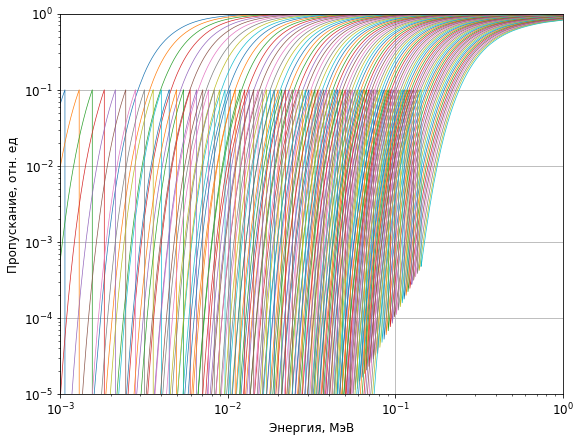

In [8]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in EDGE_METHOD_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-3, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

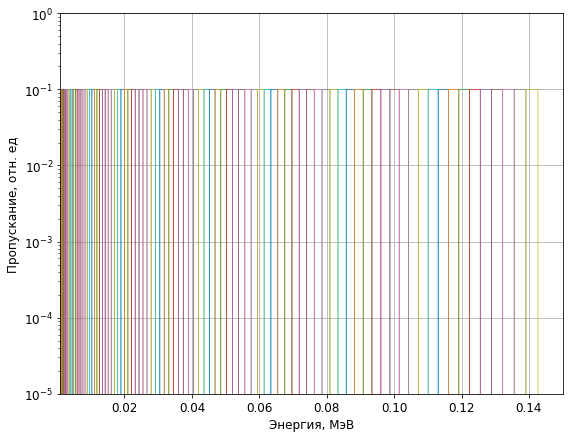

In [32]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in IDEAL_channels:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Пропускание, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
# ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-3, 0.15e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

# fig.savefig('Краевые фильты СХЧ.svg', bbox_inches='tight')

In [9]:
def split(array):
    """
    Разделяет массив на части по три элемента
    (нужно переделать функцию)
    """
    if not len(array) % 3:
        energy_mesh = np.copy(ENERGY_MESH)
        area_num = len(energy_mesh) / 3
        return np.split(energy_mesh, area_num)

    else: # если длинна массива не кратна трем убирается последняя точка
        energy_mesh = np.copy(ENERGY_MESH[:-1])
        area_num = len(energy_mesh) / 3
        return np.split(energy_mesh, area_num)

In [10]:
def polinom_coeff_h(simple_area):
    x = simple_area
    x21 = x[2]-x[1]
    x20 = x[2]-x[0]
    x10 = x[1]-x[0]
    c0 = (1/6)*x20
    c1 = (4/6)*x20
    c2 = (1/6)*x20
    return [c0, c1, c2]

In [57]:
EDGES = edges_indices()

In [58]:
len(EDGES)

564